In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import math

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping

import datetime as dt

from vrae.vrae import VRAE
from torch.utils.data import TensorDataset
import torch

Using TensorFlow backend.


In [2]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt").values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt").values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt").values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [3]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])

HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

def downsample_to(n, df, mean_window):
    new_df = pd.DataFrame()
    for col in df:
        data = df[col][1:]
#         data_temp = data.count()
        div = int(data.count() / n) - 1 # -1 bo jakies problemy sa ze avr_data po usrednieniu ma dlugosc < 200 i sa ujemne excessPoints
        avr_data = data.rolling(mean_window).mean()[::div]
        avr_data = [_ for _ in list(avr_data) if np.isnan(_) != True]
#         temp = len(avr_data)
        excess_points = len(avr_data) - n
        avr_data = avr_data[excess_points:]
        new_df[col] = pd.Series(avr_data)
#         print(f"TS {col} processing. Div: {div}. Excess points: {excess_points}. Dl: {temp}. data len: {data_temp}")
    return new_df

BP_data_scaled = downsample_to(200, BP_data_scaled, 50)
HR_data_scaled = downsample_to(200, HR_data_scaled, 50)

In [4]:
#32 -> 8 -> 2
#64 -> 16 -> 2
#128 -> 32 -> 2
#wybor parametrow

# time_steps = [32, 64, 128]
hidden_sizes = [32]
# r_layers = [0, 2, 3, 4]
# r_layers = [2]
# LSTM_cells = [1, 16, 64, 256]
# LSTM_cells = [64]
# neurons = [5, 20, 50]
# neurons = [5]
# epochs = [1, 2, 3, 4, 5]
epochs = [40]
# batch_size = [32, 64, 128]
batch_sizes = [32]
# dropout_rates = [0.2, 0.4, 0.0]
# clips = [True, False]

hidden_size = 60 # 30? 60?
hidden_layer_depth = 1 #2?
latent_length = 2 #10? 20?
batch_size = 32
learning_rate = 0.0005
n_epochs = 40 #20? 80?
dropout_rate = 0.2
optimizer = 'Adam'  # options: ADAM, SGD
cuda = False  # options: True, False
print_every = 30
clip = True  # options: True, False
max_grad_norm = 5
loss = 'MSELoss'  # options: SmoothL1Loss, MSELoss
block = 'LSTM'  # options: LSTM, GRU

In [7]:
def choose_color(label):
    if label[0] == 1.0:
        return 'r'
    elif label[0] == 0.0:
        return 'b'
    else:
        return 'm'
    
def plot_latent_space(X, Y, typ, directory):
    latent_space = vrae.transform(TensorDataset(torch.from_numpy(X)))
    lsl = latent_space.shape[0]

    X_BP_means = scale([np.mean(x[:,0]) for x in X], (0,100))
    X_HR_means = scale([np.mean(x[:,1]) for x in X], (0,100))
    label_colors = [choose_color(y) for y in Y]

    plt.figure(figsize=(12,8))
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=X_HR_means[:lsl], s=10, cmap='gist_rainbow')
    plt.savefig(f"{directory}/{typ}_HR_MEANS_LS.png")

    plt.figure(figsize=(12,8))
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=X_BP_means[:lsl], s=10, cmap='gist_rainbow')
    plt.savefig(f"{directory}/{typ}_BP_MEANS_LS.png")

    plt.figure(figsize=(12,8))
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=label_colors[:lsl], s=10)
    plt.savefig(f"{directory}/{typ}_LABELS_LS.png")
    plt.close('all')
    
def scale(x, out_range=(-1, 1), axis=None):
    domain = np.min(x, axis), np.max(x, axis)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2
            
def split(BP_data, HR_data):
    X = []
    y = []
    for col in BP_data:
        BP_HR_interval = []
        for BP_interval, HR_interval in zip(BP_data[col], HR_data[col]):
            BP_HR_interval.append([BP_interval, HR_interval])
        X.append(BP_HR_interval)
        if labels[col] == 'Synkope': label = [0., 1.] 
        else: label = [1., 0.]
        y.append(label)
    return np.array(X), np.array(y)

In [8]:
plt.ioff()
for h in hidden_sizes:
    X_train, y_train = split(BP_data_scaled[train_indices], HR_data_scaled[train_indices])
    X_test, y_test = split(BP_data_scaled[test_indices], HR_data_scaled[test_indices])
    X_validation, y_validation = split(BP_data_scaled[validation_indices], HR_data_scaled[validation_indices])
    train_dataset = TensorDataset(torch.from_numpy(X_train))
    test_dataset = TensorDataset(torch.from_numpy(X_test))
    sequence_length = X_train.shape[1]
    number_of_features = X_train.shape[2]
    for e in epochs:
        for bs in batch_sizes:            
            vrae = VRAE(sequence_length=sequence_length,
            number_of_features=number_of_features,
            hidden_size=h,
            hidden_layer_depth=hidden_layer_depth,
            latent_length=latent_length,
            batch_size=bs,
            learning_rate=learning_rate,
            n_epochs=e,
            dropout_rate=dropout_rate,
            optimizer=optimizer,
            cuda=cuda,
            print_every=print_every,
            clip=clip,
            max_grad_norm=max_grad_norm,
            loss=loss,
            block=block,
            dload='a')
            
            epoch_loss, recon_loss, kl_loss = vrae.fit(train_dataset)
            epoch_loss = round(epoch_loss, 2)
            recon_loss = round(recon_loss, 2)
            kl_loss = round(kl_loss, 2)
            directory = "VRAE_results_downsampled/" + f"LOSS{epoch_loss}_RECONLOSS{recon_loss}_KLLOSS{kl_loss}_LATENT{latent_length}_HIDDEN{h}_BS{bs}_E{e}"
            os.mkdir(directory)
            
            plot_latent_space(X_train, y_train, 'TRAIN', directory)
#             plot_latent_space(X_test, y_test, 'TEST', directory)
            del vrae

Epoch: 0
Average loss: 2943.5187
Epoch: 1
Average loss: 2517.0956
Epoch: 2
Average loss: 2200.8051
Epoch: 3
Average loss: 1843.8391
Epoch: 4
Average loss: 1572.3282
Epoch: 5
Average loss: 1296.4447
Epoch: 6
Average loss: 1084.5325
Epoch: 7
Average loss: 834.0516
Epoch: 8
Average loss: 616.1585
Epoch: 9
Average loss: 477.0796
Epoch: 10
Average loss: 343.1711
Epoch: 11
Average loss: 253.6548
Epoch: 12
Average loss: 220.6443
Epoch: 13
Average loss: 215.9546
Epoch: 14
Average loss: 227.9361
Epoch: 15
Average loss: 214.2560
Epoch: 16
Average loss: 207.8016
Epoch: 17
Average loss: 202.2023
Epoch: 18
Average loss: 210.5442
Epoch: 19
Average loss: 200.9807
Epoch: 20
Average loss: 190.8407
Epoch: 21
Average loss: 207.4619
Epoch: 22
Average loss: 194.4937
Epoch: 23
Average loss: 192.5294
Epoch: 24
Average loss: 195.8975
Epoch: 25
Average loss: 199.4757
Epoch: 26
Average loss: 197.1877
Epoch: 27
Average loss: 198.9910
Epoch: 28
Average loss: 195.2296
Epoch: 29
Average loss: 196.2353
Epoch: 30
Ave

In [13]:
plt.ion()

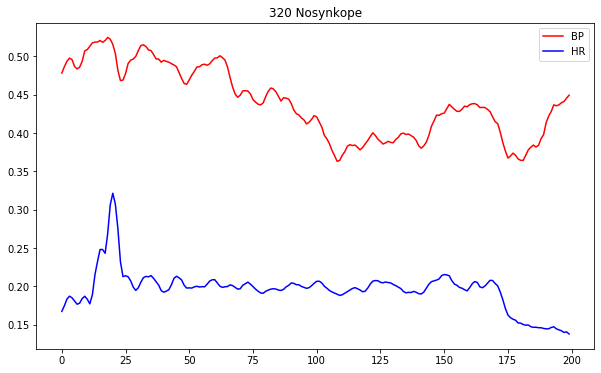

In [14]:
plt.figure(figsize=(10,6))
plt.plot(BP_data_scaled['320'], c='r')
plt.plot(HR_data_scaled['320'], c='b')
plt.title("320 Nosynkope")
plt.legend(["BP", "HR"])
plt.show()

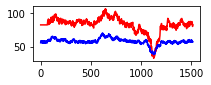

In [28]:
plt.figure(figsize=(3,1))
plt.plot(BP_data['393'][1:].astype(np.float64), c='r')
plt.plot(HR_data['393'][1:].astype(np.float64), c='b')
plt.show()